In [1]:
# 导入常规的数据分析库
from pyecharts import Bar,Pie
import pandas as pd
import numpy as np
import  matplotlib.pyplot as  plt
import time

In [2]:
# 读取评论文件，取其评论列与平分列
df=pd.read_excel("all_data_meituan.xlsx")[["comment","star"]]
df.head()

,comment,star
0,还行吧，建议不要排队那个烤鸭和羊肉串，因为烤肉时间本来就不够，排那个要半小时，然后再回来吃烤...,40
1,去过好几次了 东西还是老样子 没增添什么新花样 环境倒是挺不错 离我们这也挺近 味道还可以 ...,40
2,一个字：好！！！ #羊肉串# #五花肉# #牛舌# #很好吃# #鸡软骨# #拌菜# #抄河...,50
3,第一次来吃，之前看过好多推荐说这个好吃，真的抱了好大希望，排队的人挺多的，想吃得趁早来啊。还...,20
4,羊肉串真的不太好吃，那种说膻不膻说臭不臭的味。烤鸭还行，大虾没少吃，也就到那吃大虾了，吃完了...,30


In [3]:
# 查看数据的大小
df.shape

(17400, 2)

In [4]:
# 以30分为划分界限，大于30分的记为正类1，其余的为负类0
df['sentiment']=df['star'].apply(lambda x:1 if x>30 else 0)
df=df.drop_duplicates() ## 去掉重复的评论 
df=df.dropna()

In [5]:
# 复制数据可以使用np.tile(arr, (3, 1))，延第一个轴的方向进行数据复制3倍。
# 如果数据不复制的话，只有1100条左右的信息，数据量太小，已使用多种算法进行拟合，效果均相差较大
X=pd.concat([df[['comment']],df[['comment']],df[['comment']]])
y=pd.concat([df.sentiment,df.sentiment,df.sentiment])
X.columns=['comment']
X.reset_index
X.shape

(3138, 1)

In [6]:
import jieba
def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))
X['cut_comment']=X["comment"].apply(chinese_word_cut)
X['cut_comment'].head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HUANG_~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\HUANG_~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.873 seconds.
DEBUG:jieba:Loading model cost 0.873 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


0    还行 吧 ， 建议 不要 排队 那个 烤鸭 和 羊肉串 ， 因为 烤肉 时间 本来 就 不够...
1    去过 好 几次 了   东西 还是 老 样子   没 增添 什么 新花样   环境 倒 是 ...
2    一个 字 ： 好 ！ ！ ！   # 羊肉串 #   # 五花肉 #   # 牛舌 #   ...
3    第一次 来 吃 ， 之前 看过 好多 推荐 说 这个 好吃 ， 真的 抱 了 好 大 希望 ...
4    羊肉串 真的 不太 好吃 ， 那种 说 膻 不 膻 说 臭 不 臭 的 味 。 烤鸭 还 行...
Name: cut_comment, dtype: object

In [7]:
from sklearn.model_selection import  train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.25)

In [8]:
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file,encoding="utf-8") as f:
        custom_stopwords_list=[i.strip() for i in f.readlines()]
    return custom_stopwords_list

In [9]:
stop_words_file = "stopwords.txt"
stopwords = get_custom_stopwords(stop_words_file)
stopwords[-10:]

['100', '01', '02', '03', '04', '05', '06', '07', '08', '09']

In [10]:
from sklearn.feature_extraction.text import  CountVectorizer
vect=CountVectorizer()
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
vect.fit_transform(X_train["cut_comment"])

<2353x1965 sparse matrix of type '<class 'numpy.int64'>'
	with 20491 stored elements in Compressed Sparse Row format>

In [13]:
vect.fit_transform(X_train["cut_comment"]).toarray().shape

(2353, 1965)

In [14]:
# pd.DataFrame(vect.fit_transform(X_train["cut_comment"]).toarray(),columns=vect.get_feature_names()).iloc[:10,:22]
# print(vect.get_feature_names())
# #  数据维数1956，不算很大（未使用停用词）

In [15]:
vect = CountVectorizer(token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b',stop_words=frozenset(stopwords)) # 去除停用词
pd.DataFrame(vect.fit_transform(X_train['cut_comment']).toarray(), columns=vect.get_feature_names()).head()
# 1691 columns,去掉以数字为特征值的列，减少了三列编程1691 
# max_df = 0.8 # 在超过这一比例的文档中出现的关键词（过于平凡），去除掉。
# min_df = 3 # 在低于这一数量的文档中出现的关键词（过于独特），去除掉。

,amazing,happy,ktv,pm2,一万个,一个多,一个月,一串,一人,一件,...,麻烦,麻酱,黄喉,黄桃,黄花鱼,黄金,黑乎乎,黑椒,黑胡椒,齐全
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
# lr=LogisticRegression(solver='saga',max_iter=10000)
lr=LogisticRegression()
pipe=make_pipeline(vect,lr)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None,
          stop_words=frozenset({'', '第二讲', '从优', '云云', '亲自', '今', '後面', '将近', '反过来说', 'ones', '兮', '］', '了', '第十八', 'off', '实现', '你们', '立地', 'him', '乘隙', '到处', 'wherever', '乃至于', '全年', 'where', '进行', '一片', '从未', '日见', '既', 'nearly', '每每', '顺', '取得', '逐渐', '吗', '反之则', 'maybe', '57', '进步', 'same', '://', '路经', ... 'sure', '按说', 'therefore', '方才', '里面', '为', '但是', 'ie', '没', '恰似', '总的来说', '元／吨', '第四套', 'course'}),
          strip_accents=None, token_pattern='(?u)\\b[^\\d\\W]\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
       

In [17]:
pipe.fit(X_train.cut_comment, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [18]:
from sklearn import metrics
y_pred = pipe.predict(X_test.cut_comment)
metrics.accuracy_score(y_test,y_pred)

0.87261146496815289

In [19]:
metrics.confusion_matrix(y_test,y_pred)
#  准确率提高，同时降低了假阳性以及假阴性，saga的收敛的max_iter比默认的liblinear

array([[210,  79],
       [ 21, 475]], dtype=int64)

In [20]:
y_pred_all = pipe.predict(X['cut_comment'])
metrics.f1_score(y_true=y,y_pred=y_pred_all)
metrics.accuracy_score(y,y_pred_all)

0.9177820267686424

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
lrvc = LogisticRegressionCV(Cs=[0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,10],scoring='accuracy',solver='saga',max_iter=10000,penalty='l2',verbose=0)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
# lr=LogisticRegression(solver='saga',max_iter =10000)
pipe=make_pipeline(vect,lrvc)
# pipe=make_pipeline(vect,lr)
# pipe.steps
pipe.fit(X_train.cut_comment, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=...andom_state=None, refit=True,
           scoring='accuracy', solver='saga', tol=0.0001, verbose=0))])

In [22]:
y_pred = pipe.predict(X_test.cut_comment)
metrics.accuracy_score(y_test,y_pred)

0.89936305732484079

In [23]:
metrics.confusion_matrix(y_test,y_pred)

array([[235,  54],
       [ 25, 471]], dtype=int64)

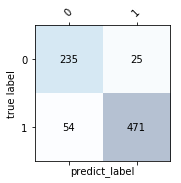

In [24]:
def get_confusion_matrix(conf,clas):
    import  matplotlib.pyplot as  plt
    fig,ax=plt.subplots(figsize=(2.5,2.5))
    ax.matshow(conf,cmap=plt.cm.Blues,alpha=0.3)
    tick_marks = np.arange(len(clas))
    plt.xticks(tick_marks,clas, rotation=45)
    plt.yticks(tick_marks, clas)
    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            ax.text(x=i,y=j,s=conf[i,j],
                   va='center',
                   ha='center')
    plt.xlabel("predict_label")
    plt.ylabel("true label")
    
conf=metrics.confusion_matrix(y_test,y_pred)
class_names=np.array(['0','1'])  # 处理二分类数据
get_confusion_matrix(np.array(conf),clas=class_names)
plt.show()